In [3]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import beta
import EpiClockNBL.src.util as pc_util
pc_consts = pc_util.consts

In [10]:
proj_dir = os.path.join(pc_consts['official_indir'], 'TARGET')
beta_peak_indir = os.path.join(pc_consts['repo_dir'], 'Beta Peak Decomposition')

In [5]:
figure_outdir = 'figures'
os.makedirs(figure_outdir, exist_ok=True)

## Prepare data

In [6]:
os.path.join(proj_dir, 'NBL.methyl.antiNonIterClustNotStuck_sites.tsv')

'/Users/grahamgumbert/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/Neuroblastoma_Paper/Datasets_test/TARGET/NBL.methyl.antiNonIterClustNotStuck_sites.tsv'

In [7]:
clinical = {}
clinical['TARGET'] = pd.read_table(os.path.join(proj_dir, 'clinical.annotated.tsv'), index_col=0)

# Import Clock beta values for TCGA
beta_values_Clock = pd.read_table(os.path.join(proj_dir, 'NBL.methyl.antiNonIterClustNotStuck_sites.tsv'),
                      index_col=0).rename(columns=pc_util.sampleToPatientID)

### Beta decomposition data

In [8]:
alpha = {}
delta = {}
phi = {}

for dataset in ['TARGET']:
    print()
    print(dataset)
    
    # Import beta decomposition raw outputs
    # i.e. beta distributions' parameters and weights
    alpha[dataset] = pd.read_table(os.path.join(beta_peak_indir, dataset, 'alpha.txt'), sep='\t')
    delta[dataset] = pd.read_table(os.path.join(beta_peak_indir, dataset, 'delta.txt'), sep='\t')
    phi[dataset] = pd.read_table(os.path.join(beta_peak_indir, dataset, 'phi.txt'), sep='\t')
    assert (np.abs(phi[dataset].sum(axis=1) - 1) < 1e-10).all() # Sanity check

    modes = (alpha[dataset] - 1)/(alpha[dataset] + delta[dataset] - 2)

    # Modes of three peaks -- Left = A, Middle, Right = B
    clinical[dataset]['beta_A'] = modes.apply(lambda x: np.sort(x)[0], axis=1)
    clinical[dataset]['beta_middle'] = modes.apply(lambda x: np.sort(x)[1], axis=1)
    clinical[dataset]['beta_B'] = modes.apply(lambda x: np.sort(x)[2], axis=1)

    # Estimates using left and right peaks
    clinical[dataset]['avg_n_flips_estA'] = -np.log(1 - 2 * clinical[dataset]['beta_A']) / 2
    clinical[dataset]['avg_n_flips_estB'] = -np.log(2 * clinical[dataset]['beta_B'] - 1) / 2

    # Use the average of the two estimates
    clinical[dataset]['avg_n_flips'] = (clinical[dataset]['avg_n_flips_estA'] + clinical[dataset]['avg_n_flips_estB']) / 2
    clinical[dataset] = clinical[dataset].loc[~clinical[dataset]['avg_n_flips'].isna()]

    # Exclude tumors with middle peaks outside of [0.4, 0.6]
    centered_middle_mask = (clinical[dataset]['beta_middle'] >= 0.4) & (clinical[dataset]['beta_middle'] <= 0.6)
    clinical[dataset] = clinical[dataset].loc[centered_middle_mask]
    print(f'{(~centered_middle_mask).sum()} tumors removed for uncentered middle peaks')


TARGET


FileNotFoundError: [Errno 2] No such file or directory: '/Users/grahamgumbert/Documents/GitHub/EpiClockNBL/Beta Peak Decomposition/TARGET/alpha.txt'

In [6]:
# clinical[dataset].loc[['TARGET-30-PARGUX', 'TARGET-30-PARIRD']]

## 3 example tumors w/ beta dists.

In [7]:
## Configure graph
# sf = pc_consts['sf']
sf = 1
figsize = np.array([7, 6])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

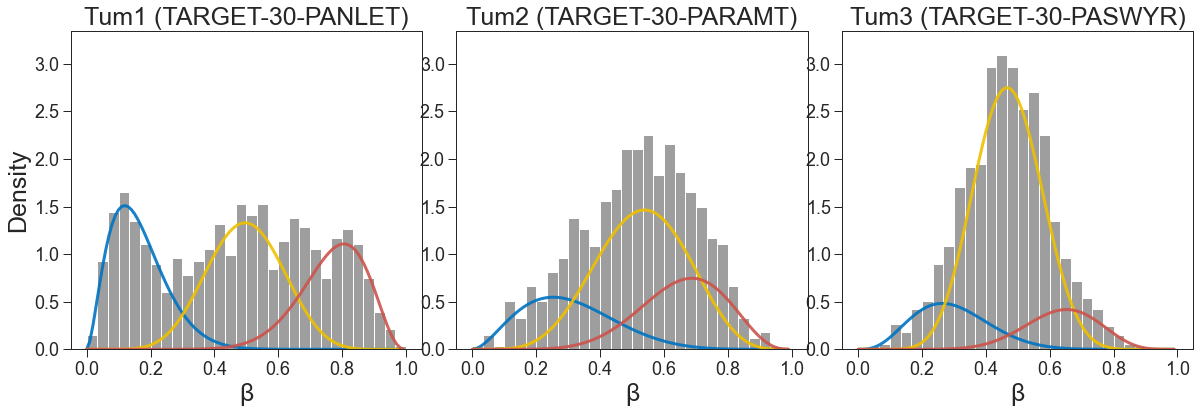

In [8]:
patient_list = {
#     'Tum1':'TARGET-30-PANLET',
    'Tum1':'TARGET-30-PANLET',
               'Tum2':'TARGET-30-PARAMT',
               'Tum3':'TARGET-30-PASWYR'}

# Create plot axes
fig, axes = plt.subplots(1, len(patient_list), figsize=np.array(figsize) * [2.3, 0.8] * sf)
fig.tight_layout(pad=0.2)

# Color of each distribution in order (left -> right)
chosen_tumor_colors = [pc_consts['palette_jco'][i] for i in [0, 1, 3]]

for i, patient in enumerate(patient_list):
    ax = axes[i]
    samp = patient_list[patient]
    
    # Plot distribution
    sns.histplot(ax=ax, x=beta_values_Clock[samp], stat='density',
                 color=pc_consts['palette_jco'][2],
                 bins=30, alpha=pc_consts['opacity'],
                binrange=(0, 1))
    
    # Customize plot
    ax.set_title(f'{patient} ({samp})', fontsize=pc_consts['labelfontsize'] * sf)
    ax.set_xlabel('β', fontsize=pc_consts['labelfontsize'] * sf)
    if i == 0: # Only have y-axis label on left-most plot
        ax.set_ylabel('Density', fontsize=pc_consts['labelfontsize'] * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

    # Weight of each of three distributions
    weight_list = phi['TARGET'].loc[samp]
    
    # Holds the max y-axis limit max
    y_max = float('-Inf')
    
    # Plot each distribution
    for j, model in enumerate(alpha['TARGET'].columns):
        
        # Beta dist. parameters
        a = alpha['TARGET'].loc[samp, model]
        d = delta['TARGET'].loc[samp, model]

        # X and Y coords for corve
        x = np.linspace(0, 0.99, 100)
        y = beta.pdf(x, a, d) * weight_list[j]
        
        # Plot curve
        ax.plot(x, y, lw=3, alpha=0.9,
                color=chosen_tumor_colors[j]
               )
        
        # Update max
        y_max = max(y_max, ax.get_ylim()[1])

# Align y-axis limits
for i in range(len(patient_list)):
    ax = axes[i]
    ax.set_ylim(0, y_max * 1.03)

# Save figure
# fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)

In [9]:
clinical[dataset].loc[(clinical[dataset]['beta_A'] < 0.12) & (clinical[dataset]['beta_B'] > 0.8)]

,project,disease_type,primary_site,submitter_id.1,inss_stage,days_to_diagnosis,created_datetime,treatments,last_known_disease_status,tissue_or_organ_of_origin,...,c_beta,c_beta_traditional,LUMP,Age,beta_A,beta_middle,beta_B,avg_n_flips_estA,avg_n_flips_estB,avg_n_flips
submitter_id,,,,,,,,,,,,,,,,,,,,,
TARGET-30-PANBSP,TARGET-NBL,Neuroepitheliomatous Neoplasms,Kidney,TARGET-30-PANBSP,Stage 4,0.0,2016-04-25T16:38:00.753908-05:00,"c(\ANBL00B1\"", \""A3973\""), c(\""2024-03-13T17:1...",NaN,"Kidney, NOS",...,0.665869,0.606563,0.712484,2.915068,0.07108,0.494461,0.905591,0.076668,0.104631,0.090650
TARGET-30-PANLET,TARGET-NBL,Neuroepitheliomatous Neoplasms,Adrenal gland,TARGET-30-PANLET,Stage 4,0.0,2016-04-25T16:38:27.458804-05:00,"c(\ANBL0421\"", \""ANBL00B1\""), c(\""2024-03-13T1...",NaN,"Adrenal gland, NOS",...,0.743716,0.702271,0.651155,5.405479,0.11916,0.496165,0.805898,0.136115,0.245678,0.190897


## Estimation

In [33]:
young_tumors.shape

(21,)

In [34]:
(clinical[dataset]['age_at_diagnosis'] <= 50).sum()

12

alpha * mu = 0.00193


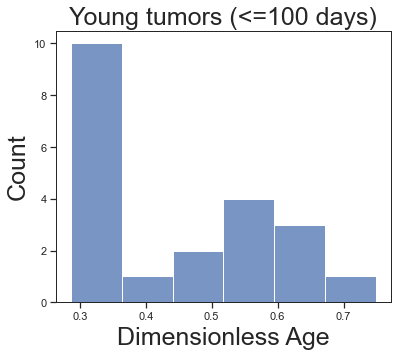

In [10]:
dataset = 'TARGET'

# Young patients - less than 100 days
young_tumors = clinical[dataset].index[clinical[dataset]['age_at_diagnosis'] <= 100]

# Average calendar age should be 50 days plus 6 months
approx_avg_calAge = 50 + 6*30

fig, ax = plt.subplots(figsize=np.array([6, 5])*sf)
sns.histplot(ax=ax, data=clinical[dataset].loc[young_tumors], x='avg_n_flips')
ax.set_xlabel('Dimensionless Age', fontsize=pc_consts['labelfontsize']*sf)
ax.set_title('Young tumors (<=100 days)', fontsize=pc_consts['labelfontsize']*sf)
ax.set_ylabel('Count', fontsize=pc_consts['labelfontsize']*sf)

alpha_mu = clinical[dataset].loc[young_tumors]['avg_n_flips'].mean() / approx_avg_calAge
print(f'alpha * mu = {alpha_mu:.5f}')

In [11]:
dataset = 'TARGET'

# Calculate calendar ages
clinical[dataset]['calendar_age'] = clinical[dataset]['avg_n_flips'] / alpha_mu
clinical[dataset].name = 'TARGET'

## Plots

### Young tumors

Text(0.5, 1.0, 'TARGET,\nyoung tumors (<=100 days)')

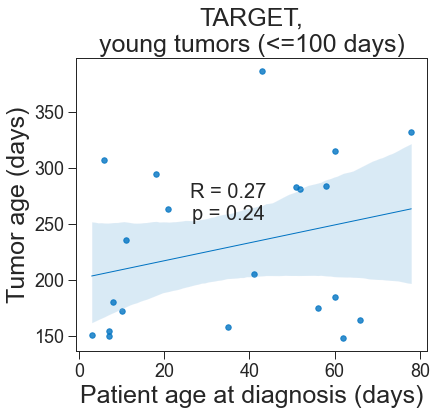

In [12]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

cor_res = pc_util.getCorrelation(clinical[dataset], 'age_at_diagnosis', 'calendar_age', use_samples=young_tumors)

text_x = 35
text_y = 270
pc_util.saveCorrelationPlot(clinical[dataset], var_y='calendar_age',
                           var_x='age_at_diagnosis', use_samples=young_tumors,
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Patient age at diagnosis (days)', ylabel='Tumor age (days)',
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-20, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nyoung tumors (<=100 days)', fontsize=pc_consts['labelfontsize'] * sf)

### Old tumors

Text(0.5, 1.0, 'TARGET,\nold tumors (>=100 days)')

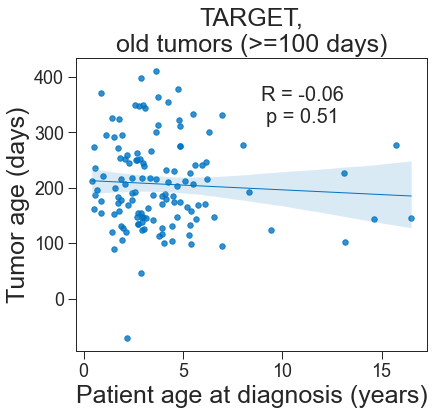

In [13]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

old_tumors = clinical[dataset].index[~np.isin(clinical[dataset].index, young_tumors)]

cor_res = pc_util.getCorrelation(clinical[dataset], 'Age', 'calendar_age', use_samples=old_tumors)

text_x = 11
text_y = 350
pc_util.saveCorrelationPlot(clinical[dataset], var_y='calendar_age',
                           var_x='Age', use_samples=old_tumors,
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Patient age at diagnosis (years)', ylabel='Tumor age (days)',
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-40, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nold tumors (>=100 days)', fontsize=pc_consts['labelfontsize'] * sf)

### All tumors

Text(0.5, 1.0, 'TARGET,\nall tumors')

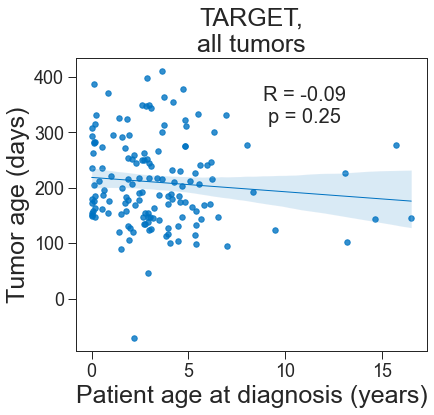

In [14]:
fig, ax = plt.subplots(figsize = figsize * 0.9 * sf)

cor_res = pc_util.getCorrelation(clinical[dataset], 'Age', 'calendar_age')

text_x = 11
text_y = 350
pc_util.saveCorrelationPlot(clinical[dataset], var_y='calendar_age',
                           var_x='Age',
                             outfile=False, ax=ax,
                           text_x=text_x, text_y=text_y,
#                            figsize=figsize * 0.9,
                            xlabel='Patient age at diagnosis (years)', ylabel='Tumor age (days)',
                            labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=30,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

ax.text(text_x, text_y-40, f'p = {cor_res.pvalue:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf)
ax.set_title(ax.get_title() + ',\nall tumors', fontsize=pc_consts['labelfontsize'] * sf)

In [31]:
clinical[dataset].loc['TARGET-30-PAIXFZ']

project                                                                     TARGET-NBL
disease_type                                            Neuroepitheliomatous Neoplasms
primary_site                                                                   Unknown
submitter_id.1                                                        TARGET-30-PAIXFZ
inss_stage                                                                    Stage 4S
days_to_diagnosis                                                                  0.0
created_datetime                                      2016-04-25T16:33:30.343664-05:00
treatments                           9047, 2024-03-13T17:13:56.180548-05:00, 1158e5...
last_known_disease_status                                                          NaN
tissue_or_organ_of_origin                                                      Unknown
days_to_last_follow_up                                                             NaN
age_at_diagnosis                           

In [24]:
pc_util.getCorrelation(clinical[dataset], 'calendar_age', 'Age')

LinregressResult(slope=-0.005015284481183228, intercept=0.4236214874690084, rvalue=-0.0947147014161901, pvalue=0.2538205079827469, stderr=0.004377613206709258, intercept_stderr=0.019423492508295368)

In [22]:
pc_util.getCorrelation(clinical[dataset], 'c_beta', 'Age')

LinregressResult(slope=-0.0029105766187311278, intercept=0.8246455832919816, rvalue=-0.2366321095182712, pvalue=0.003906457890659641, stderr=0.0009924498338055897, intercept_stderr=0.004403505061214089)

## Examine calendar age vs $c_\beta$

In [19]:
pc_util.getCorrelation(clinical[dataset], 'calendar_age', 'c_beta')

LinregressResult(slope=1745.8389991191646, intercept=-1212.4257461730065, rvalue=0.7846358786305487, pvalue=6.552834345235968e-32, stderr=114.55485852240582, intercept_stderr=93.44251107421576)

<Axes: xlabel='c_beta', ylabel='calendar_age'>

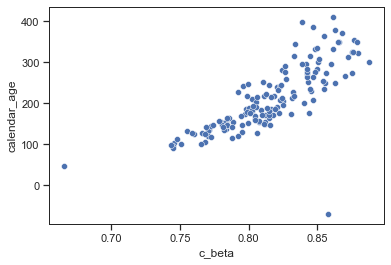

In [16]:
sns.scatterplot(data=clinical[dataset], x='c_beta', y='calendar_age')

In [17]:
# Outliers in above plot
outlier_tumors = clinical[dataset].loc[clinical[dataset]['calendar_age'] < 80].index.values

# Correlation without outliers
pc_util.getCorrelation(clinical[dataset], 'calendar_age', 'c_beta', use_samples=clinical[dataset].index[~np.isin(clinical[dataset].index, outlier_tumors)])

LinregressResult(slope=1925.1236149229258, intercept=-1356.8686309173654, rvalue=0.858675070542134, pvalue=2.384043871424806e-43, stderr=96.08882304591118, intercept_stderr=78.44115356203451)

### Examine outlier tumors

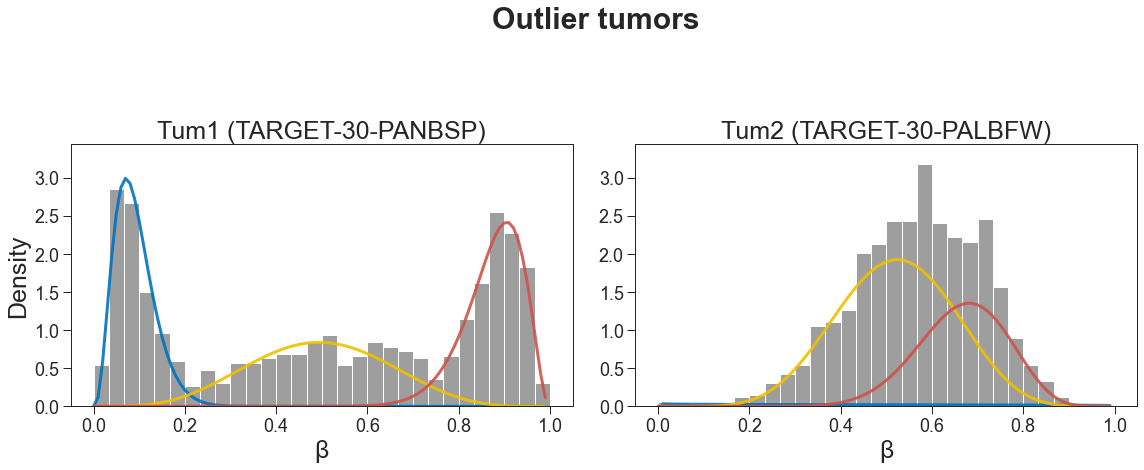

In [18]:
patient_list = {
    'Tum1':outlier_tumors[0],
    'Tum2':outlier_tumors[1]
}

# Create plot axes
fig, axes = plt.subplots(1, len(patient_list), figsize=np.array(figsize) * [2.3, 0.8] * sf)
fig.tight_layout(pad=3)
fig.suptitle('Outlier tumors', y=1.3, fontsize=pc_consts['labelfontsize'] * 1.2 * sf, fontweight='bold')

# Color of each distribution in order (left -> right)
chosen_tumor_colors = [pc_consts['palette_jco'][i] for i in [0, 1, 3]]

for i, patient in enumerate(patient_list):
    ax = axes[i]
    samp = patient_list[patient]
    
    # Plot distribution
    sns.histplot(ax=ax, x=beta_values_Clock[samp], stat='density',
                 color=pc_consts['palette_jco'][2],
                 bins=30, alpha=pc_consts['opacity'],
                binrange=(0, 1))
    
    # Customize plot
    ax.set_title(f'{patient} ({samp})', fontsize=pc_consts['labelfontsize'] * sf)
    ax.set_xlabel('β', fontsize=pc_consts['labelfontsize'] * sf)
    if i == 0: # Only have y-axis label on left-most plot
        ax.set_ylabel('Density', fontsize=pc_consts['labelfontsize'] * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

    # Weight of each of three distributions
    weight_list = phi['TARGET'].loc[samp]
    
    # Holds the max y-axis limit max
    y_max = float('-Inf')
    
    # Plot each distribution
    for j, model in enumerate(alpha['TARGET'].columns):
        
        # Beta dist. parameters
        a = alpha['TARGET'].loc[samp, model]
        d = delta['TARGET'].loc[samp, model]

        # X and Y coords for corve
        x = np.linspace(0, 0.99, 100)
        y = beta.pdf(x, a, d) * weight_list[j]
        
        # Plot curve
        ax.plot(x, y, lw=3, alpha=0.9,
                color=chosen_tumor_colors[j]
               )
        
        # Update max
        y_max = max(y_max, ax.get_ylim()[1])

# Align y-axis limits
for i in range(len(patient_list)):
    ax = axes[i]
    ax.set_ylim(0, y_max * 1.03)

# Save figure
# fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)